### Text Preprocessing and Vectorization

Earlier, we created a dataset containing 10,000 tracks across 80 playlists, along with lyrics and other metadata.
Here, we use NLP techniques to preprocess, vectorize (using BoW, TF-IDF, and GloVe), and perform topic modeling (using LDA) on the track lyrics.

In [ ]:
# generally helpful
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statistics

# for text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer

# for text vectorization
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.models.coherencemodel import CoherenceModel
from gensim import downloader
from gensim.models.phrases import Phrases

# for topic modeling
import seaborn as sns
from gensim.models.ldamodel import LdaModel
import pyLDAvis.gensim as gensimvis
import pyLDAvis

# for k-means clustering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Load dataset from csv file

In [ ]:
# Load in the playlists dataset from csv file

df = pd.read_csv('playlist_dataset.csv')
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Playlist ID,Playlist Name,Track Name,Artist Name,Album Name,Track URI,Lyrics
0,30,Garage Rock,Take My Side,Will Butler,Policy,spotify:track:6v4zAuJTlszNdKrbbnEFu8,Where's the fire? Let it burn\nWhere're the ch...
1,30,Garage Rock,Everyday it Starts,Parquet Courts,Content Nausea,spotify:track:25JD35LDh7CEJ9gKUNruVj,Everyday it starts\nEveryday it starts\nEveryd...
2,30,Garage Rock,Content Nausea,Parquet Courts,Content Nausea,spotify:track:24bk2iKzr3VcymFnzIy3oS,"Content nausea, World War Four\nSeems like it ..."
3,30,Garage Rock,Slide Machine,Parquet Courts,Content Nausea,spotify:track:7rjK8CDTtTn2KG9Zja7ETj,I've been down South where they use the slide ...
4,30,Garage Rock,Pretty Machines,Parquet Courts,Content Nausea,spotify:track:1zPn4tfkWfowVG3ROo1wUY,"Ah, moonlight\nIt's hard to believe it\nAnd it..."


In [ ]:
# As a reminder, here are some statistics on the dataframe

# Tracks Stats
print("Number of total tracks:", len(df))
print("Number of unique tracks:", df['Track URI'].nunique())
track_uri_counts = df.groupby('Track URI').size()
repeated_tracks = track_uri_counts[track_uri_counts > 1]
print("Number of repeated tracks:", len(repeated_tracks))

# Playlist Stats
print("Number of playlists:", df['Playlist ID'].nunique())
tracks_per_plist = df.groupby('Playlist ID').size()
print("Mean number of tracks per playlist:", tracks_per_plist.mean())
print("Standard deviation of tracks per playlist:", tracks_per_plist.std())

Number of total tracks: 9887
Number of unique tracks: 7704
Number of repeated tracks: 1360
Number of playlists: 72
Mean number of tracks per playlist: 137.31944444444446
Standard deviation of tracks per playlist: 10.015236827009906


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Text Preprocessing Pipeline with NLTK

In [ ]:
# Set up for NLTK
nltk.download('stopwords')
default_stopwords = stopwords.words('english')
custom_stopwords = ['oh', 'ooh', 'ohh', 'ah', 'eh', 'ehh', 'uh', 'la', 'wa', 'u', 'mmm', 'yeah', 'ya', 'woah', 'gonna', 'finna', 'cause', 'em', 'ay', 'da']

# Add custom stopwords to list
all_stopwords_set = set(default_stopwords + custom_stopwords)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# # TEST: Determining some custom stopwords for song lyrics

# # See what some default stopwords are
# print(default_stopwords)

# # Check if potential stopword is already in default list
# print('ya' in default_stopwords)

# # Examine some song lyrics to find potential custom stopwords
# print(df['lyrics'][0])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Function for text preprocessing pipeline

def preprocess_text(text):

    # Tokenize each line at the word level
    tokens = wordpunct_tokenize(text)

    # Homogenization
    # lowercase tokens
    tokens_lower = [t.lower() for t in tokens]
    # keep only alphanumeric tokens
    tokens_lower_an = [t for t in tokens_lower if t.isalnum()]
    # lemmatization
    wnl = WordNetLemmatizer()
    lemmatized = [wnl.lemmatize(t) for t in tokens_lower_an]

    # Cleaning
    # remove stopwords
    cleaned = [t for t in lemmatized if t not in all_stopwords_set]

    return cleaned


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# # TEST: Testing preprocess_text function
# lyrics = df['Lyrics'][0]
# print("Original:", repr(lyrics))
# preprocessed_lyrics = preprocess_text(lyrics)
# print("Preprocessed:", preprocessed_lyrics)

Original: "Where's the fire? Let it burn\nWhere're the children? Oh, children, you gotta learn\nI'll tell you why when I figure it out myself\nOh, please don't cry; your crying, it ain't gonna help\n\nWhere we going? Where you taking me?\nIf you want it, you know you can set me free\nI'd tell you why but I'm having problems with my words\nIf I could fly, you know I'd beat the shit out of some birds\n\nI remember when we were pretty young\nWhere we'd often run together to the setting of the sun\nOh, we swore we're friends forever, so before you run and hide, just tell me:\n\nAre you gonna take my side?\nAre you gonna take my side?\nAre you be on my side or their side?\nAre you gonna take my side?\n\nWhat's the difference if I'm wrong?\nKeep on acting, we'll never get along\nI'll tell you why but you'd probably figure it out yourself\nOh, you're so wise, you best put that book back on the shelf\n\nI remember when we were pretty young\nWhere we often stayed together to the rising of the s

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Preprocess all Lyrics

In [ ]:
# WARNING: This cell takes around 50 seconds to run!

# Iterate through all rows of df
# For each, preprocess the relevant fields and add preprocessed text as a col to df
# Create a new df with preprocessing results

new_data = []
nltk.download('wordnet')

# For now, we will preprocess fields that contain text
fields = ['Lyrics', 'Playlist Name', 'Track Name', 'Album Name']

for index, row in df.iterrows():
    new_row = row.copy()
    for f in fields:
          new_col = 'Preprocessed ' + f
          new_row[new_col] = preprocess_text(row[f])
    new_data.append(new_row)

new_df = pd.DataFrame(new_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Verify results of preprocessing
print("Number of rows in original df:", len(df))
print("Number of rows in new df after preprocessing:", len(new_df))
print(new_df['Preprocessed Lyrics'].dtype)
new_df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of rows in original df: 9887
Number of rows in new df after preprocessing: 9887
object


,Playlist ID,Playlist Name,Track Name,Artist Name,Album Name,Track URI,Lyrics,Preprocessed Lyrics,Preprocessed Playlist Name,Preprocessed Track Name,Preprocessed Album Name
0,30,Garage Rock,Take My Side,Will Butler,Policy,spotify:track:6v4zAuJTlszNdKrbbnEFu8,Where's the fire? Let it burn\nWhere're the ch...,"[fire, let, burn, child, child, gotta, learn, ...","[garage, rock]","[take, side]",[policy]
1,30,Garage Rock,Everyday it Starts,Parquet Courts,Content Nausea,spotify:track:25JD35LDh7CEJ9gKUNruVj,Everyday it starts\nEveryday it starts\nEveryd...,"[everyday, start, everyday, start, everyday, s...","[garage, rock]","[everyday, start]","[content, nausea]"
2,30,Garage Rock,Content Nausea,Parquet Courts,Content Nausea,spotify:track:24bk2iKzr3VcymFnzIy3oS,"Content nausea, World War Four\nSeems like it ...","[content, nausea, world, war, four, seems, lik...","[garage, rock]","[content, nausea]","[content, nausea]"
3,30,Garage Rock,Slide Machine,Parquet Courts,Content Nausea,spotify:track:7rjK8CDTtTn2KG9Zja7ETj,I've been down South where they use the slide ...,"[south, use, slide, machine, god, overheard, s...","[garage, rock]","[slide, machine]","[content, nausea]"
4,30,Garage Rock,Pretty Machines,Parquet Courts,Content Nausea,spotify:track:1zPn4tfkWfowVG3ROo1wUY,"Ah, moonlight\nIt's hard to believe it\nAnd it...","[moonlight, hard, believe, harder, need, easil...","[garage, rock]","[pretty, machine]","[content, nausea]"


Max number of tokens in preprocessed lyrics: 969
Min number of tokens in preprocessed lyrics: 2
Mean number of tokens in preprocessed lyrics: 184.55709517548297
Std dev of tokens in preprocessed lyrics: 106.4435757997084


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Distribution of Number of Tokens in Preprocessed Lyrics')

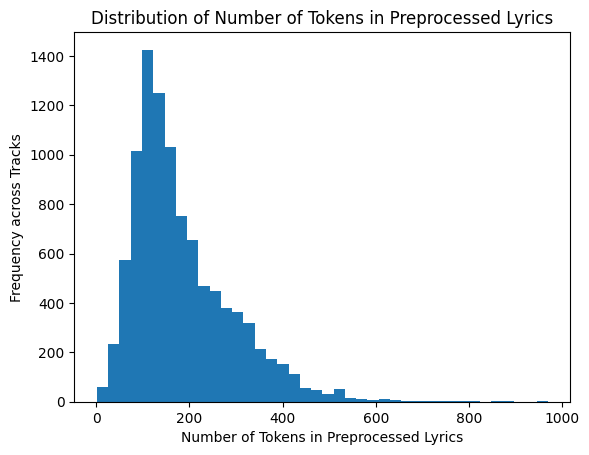

In [ ]:
# Visualization: Plot number of tokens per review

preprocessed_lyrics_lens = new_df['Preprocessed Lyrics'].apply(len)

print("Max number of tokens in preprocessed lyrics:", max(preprocessed_lyrics_lens))
print("Min number of tokens in preprocessed lyrics:", min(preprocessed_lyrics_lens))
print("Mean number of tokens in preprocessed lyrics:", preprocessed_lyrics_lens.mean())
print("Std dev of tokens in preprocessed lyrics:", preprocessed_lyrics_lens.std())

plt.hist(preprocessed_lyrics_lens, bins=40)
plt.xlabel('Number of Tokens in Preprocessed Lyrics')
plt.ylabel('Frequency across Tracks')
plt.title('Distribution of Number of Tokens in Preprocessed Lyrics')

#### Preparing Corpus & Dictionary for Text Vectorization

In [ ]:
# Create Gensim corpus (list of documents) and dictionary
corpus = []
for index, row in new_df.iterrows():
    corpus.append(row['Preprocessed Lyrics'])

D = Dictionary(corpus)

print("Number of tokens across all preprocessed lyrics:", sum(len(doc) for doc in corpus))
print("Number of unique tokens across all preprocessed lyrics:", len(D))

print(D)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of tokens across all preprocessed lyrics: 1824716
Number of unique tokens across all preprocessed lyrics: 38109
Dictionary<38109 unique tokens: ['acting', 'along', 'back', 'beat', 'best']...>


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Max number of unique token occurrences: 29229
Min number of unique token occurrences: 1
Mean number of unique token occurrences: 47.88149780891653
Std dev of unique token occurrences: 450.0622465154519


Text(0, 0.5, 'Frequency')

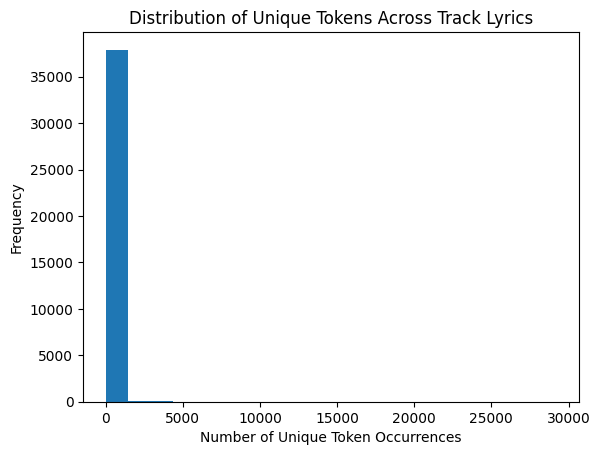

In [ ]:
# Visualization: Plot histogram of number of tokens across all preprocessed lyrics

token_counts = Counter(t for doc in corpus for t in doc)

print("Max number of unique token occurrences:", max(token_counts.values()))
print("Min number of unique token occurrences:", min(token_counts.values()))
print("Mean number of unique token occurrences:", statistics.mean(token_counts.values()))
print("Std dev of unique token occurrences:", statistics.stdev(token_counts.values()))

plt.hist(token_counts.values(), bins=20)
plt.title("Distribution of Unique Tokens Across Track Lyrics")
plt.xlabel("Number of Unique Token Occurrences")
plt.ylabel("Frequency")

#### Removing tokens that appear in exactly one document

In [ ]:
# Removing tokens that appear in exactly one document
# Ultimately, we found that the data is extremely skewed right, so it will be necessary to filter out a lot more tokens

token_counts = Counter(t for doc in corpus for t in set(doc))

# Remove tokens that appear in the lyrics of exactly one track
tokens_one_doc = [t for t, count in token_counts.items() if count == 1]
print("Some tokens that appear in the lyrics of exactly one track:", tokens_one_doc[:10])

print("Number of unique tokens:", len(D))
D.filter_tokens(bad_ids=[D.token2id[t] for t in tokens_one_doc])
print("Number of unique tokens after removing tokens that appear in only one track:", len(D))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Some tokens that appear in the lyrics of exactly one track: ['cognizance', 'strum', 'dissapointing', 'inconvenient', 'sparseness', 'consequential', 'enlisted', 'apparatus', 'protester', 'overpopulated']
Number of unique tokens: 38109
Number of unique tokens after removing tokens that appear in only one track: 21976


#### Filtering out tokens that appear in too many or too few documents

In [ ]:
# Set min number of documents a token must be in to be kept
min_thresh = 0.005 * len(corpus)  # 0.5% of tracks

# Set max proportion of documents a token can be in to be kept
max_thresh = 0.9  # 90%

print("Number of unique tokens:", len(D))
D.filter_extremes(no_below=min_thresh, no_above=max_thresh)
print("Number of unique tokens after removing extremes", len(D))

Number of unique tokens: 21976
Number of unique tokens after removing extremes 2268


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Bonus: N-gram detection

In [ ]:
# We will not replace tokens in our corpus with the detected N-grams
# However, it is interesting to see what kinds of tokens appear next to each other with high frequency

phrase_model = Phrases(corpus, min_count=2, threshold=20)
ngram_corpus = [phrase_model[doc] for doc in corpus]
ngrams = [n for doc in ngram_corpus for n in doc if '_' in n]

print("First lyrics in corpus:", corpus[0])
print("Some N-grams that were detected", ngrams[:20])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


First lyrics in corpus: ['fire', 'let', 'burn', 'child', 'child', 'gotta', 'learn', 'tell', 'figure', 'please', 'cry', 'cry', 'help', 'going', 'taking', 'want', 'know', 'set', 'free', 'tell', 'problem', 'word', 'could', 'fly', 'know', 'beat', 'shit', 'bird', 'remember', 'pretty', 'young', 'often', 'run', 'together', 'setting', 'sun', 'swore', 'friend', 'forever', 'run', 'hide', 'tell', 'take', 'side', 'take', 'side', 'side', 'side', 'take', 'side', 'difference', 'wrong', 'keep', 'acting', 'never', 'get', 'along', 'tell', 'probably', 'figure', 'wise', 'best', 'put', 'book', 'back', 'shelf', 'remember', 'pretty', 'young', 'often', 'stayed', 'together', 'rising', 'sun', 'swore', 'friend', 'forever', 'run', 'hide', 'tell', 'take', 'side', 'take', 'side', 'side', 'side', 'take', 'side', 'remember', 'pretty', 'young', 'often', 'sing', 'together', 'rising', 'sun', 'swore', 'together', 'run', 'hide', 'tell', 'take', 'side', 'take', 'side', 'side', 'side', 'take', 'side', 'know', 'would', 'die'

### Text Vectorization (BoW and GloVe)

In [ ]:
# BOW
lyrics_bow = [D.doc2bow(doc) for doc in corpus]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# GloVe: Function to get word embedding from Dictionary with unique tokens

def get_word_embeddings(D):
    glove_word_embeddings = {}
    for id, word in D.items():
        if word in glove:
            glove_word_embeddings[word] = glove[word]
        else:
            pass  # skip words in our corpus that are not known by glove
    return glove_word_embeddings

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
glove = downloader.load('glove-wiki-gigaword-50')
word_embeddings_dict = get_word_embeddings(D)
pairs = list(word_embeddings_dict.items())
print("A word and its embedding:", pairs[0])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[==================================================] 100.0% 66.0/66.0MB downloaded
A word and its embedding: ('acting', array([-0.12463 , -0.36091 , -0.88657 , -0.31956 ,  0.60212 , -0.012362,
        0.36821 ,  0.40922 , -0.4401  , -0.11301 ,  0.59804 ,  0.9162  ,
       -0.35624 ,  0.7517  ,  0.02328 ,  0.047312,  0.17178 ,  0.73718 ,
        0.29529 , -0.13406 ,  0.78404 ,  0.66677 ,  0.65047 ,  0.16076 ,
       -0.17315 , -1.7687  ,  0.063239, -0.1149  , -0.7126  ,  0.27788 ,
        2.2757  ,  0.064705, -0.14478 , -1.4266  ,  0.26385 ,  0.56771 ,
        0.24842 ,  0.42772 , -0.2513  , -0.056937, -0.51992 ,  1.0762  ,
       -0.48401 , -0.70721 , -0.31532 , -0.72874 , -0.60768 , -0.03872 ,
       -0.088638,  1.2891  ], dtype=float32))


In [ ]:
# Function to calculate embedding of lyrics (a list of words) by finding the mean of all word embeddings in lyrics

def get_mean_embedding(preprocessed_lyrics, embeddings_dict):
    vectors = []
    # Iterate over lyrics
    for w in preprocessed_lyrics:
        if w in embeddings_dict:
            vectors.append(embeddings_dict[w])
    # Calculate mean
    return np.mean(vectors, axis=0)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# # TEST: Testing get_mean_embeddings function
# lyrics = new_df['Preprocessed Lyrics'][0]
# lyrics_embedding = get_mean_embedding(lyrics, word_embeddings_dict)
# print("Original:", repr(lyrics))
# print("Lyrics embedding:", lyrics_embedding)

Original: ['fire', 'let', 'burn', 'child', 'child', 'gotta', 'learn', 'tell', 'figure', 'please', 'cry', 'cry', 'help', 'going', 'taking', 'want', 'know', 'set', 'free', 'tell', 'problem', 'word', 'could', 'fly', 'know', 'beat', 'shit', 'bird', 'remember', 'pretty', 'young', 'often', 'run', 'together', 'setting', 'sun', 'swore', 'friend', 'forever', 'run', 'hide', 'tell', 'take', 'side', 'take', 'side', 'side', 'side', 'take', 'side', 'difference', 'wrong', 'keep', 'acting', 'never', 'get', 'along', 'tell', 'probably', 'figure', 'wise', 'best', 'put', 'book', 'back', 'shelf', 'remember', 'pretty', 'young', 'often', 'stayed', 'together', 'rising', 'sun', 'swore', 'friend', 'forever', 'run', 'hide', 'tell', 'take', 'side', 'take', 'side', 'side', 'side', 'take', 'side', 'remember', 'pretty', 'young', 'often', 'sing', 'together', 'rising', 'sun', 'swore', 'together', 'run', 'hide', 'tell', 'take', 'side', 'take', 'side', 'side', 'side', 'take', 'side', 'know', 'would', 'die', 'side', 'tel

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Calculate lyrics embeddings for all preprocessed lyrics in dataframe
# Add resulting embedding as col in new dataframe
# Note that we can vectorize any/all of the preprocessed fields, but this time, we will focus on lyrics and playlist_name

final_data = []

for index, row in new_df.iterrows():
    new_row = row.copy()
    new_col = 'Lyrics Embedding'
    new_row[new_col] = get_mean_embedding(row['Preprocessed Lyrics'], word_embeddings_dict)
    new_col = 'Playlist Name Embedding'
    new_row[new_col] = get_mean_embedding(row['Preprocessed Playlist Name'], word_embeddings_dict)
    final_data.append(new_row)

final_df = pd.DataFrame(final_data)

In [ ]:
final_df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Playlist ID,Playlist Name,Track Name,Artist Name,Album Name,Track URI,Lyrics,Preprocessed Lyrics,Preprocessed Playlist Name,Preprocessed Track Name,Preprocessed Album Name,Lyrics Embedding,Playlist Name Embedding
0,30,Garage Rock,Take My Side,Will Butler,Policy,spotify:track:6v4zAuJTlszNdKrbbnEFu8,Where's the fire? Let it burn\nWhere're the ch...,"[fire, let, burn, child, child, gotta, learn, ...","[garage, rock]","[take, side]",[policy],"[0.14704275, 0.18749574, 0.027559102, -0.36198...","[-0.6467, 0.98998, -0.14379, -0.0030598, -0.65..."
1,30,Garage Rock,Everyday it Starts,Parquet Courts,Content Nausea,spotify:track:25JD35LDh7CEJ9gKUNruVj,Everyday it starts\nEveryday it starts\nEveryd...,"[everyday, start, everyday, start, everyday, s...","[garage, rock]","[everyday, start]","[content, nausea]","[0.14214703, 0.13033065, -0.1995055, -0.361942...","[-0.6467, 0.98998, -0.14379, -0.0030598, -0.65..."
2,30,Garage Rock,Content Nausea,Parquet Courts,Content Nausea,spotify:track:24bk2iKzr3VcymFnzIy3oS,"Content nausea, World War Four\nSeems like it ...","[content, nausea, world, war, four, seems, lik...","[garage, rock]","[content, nausea]","[content, nausea]","[0.2363391, 0.17119373, 0.03917369, -0.2821858...","[-0.6467, 0.98998, -0.14379, -0.0030598, -0.65..."
3,30,Garage Rock,Slide Machine,Parquet Courts,Content Nausea,spotify:track:7rjK8CDTtTn2KG9Zja7ETj,I've been down South where they use the slide ...,"[south, use, slide, machine, god, overheard, s...","[garage, rock]","[slide, machine]","[content, nausea]","[-0.04323885, -0.032407302, 0.3804018, -0.9310...","[-0.6467, 0.98998, -0.14379, -0.0030598, -0.65..."
4,30,Garage Rock,Pretty Machines,Parquet Courts,Content Nausea,spotify:track:1zPn4tfkWfowVG3ROo1wUY,"Ah, moonlight\nIt's hard to believe it\nAnd it...","[moonlight, hard, believe, harder, need, easil...","[garage, rock]","[pretty, machine]","[content, nausea]","[0.11442823, 0.0718515, 0.057495397, -0.275225...","[-0.6467, 0.98998, -0.14379, -0.0030598, -0.65..."


### Analyzing BOW: Topic Modeling with LDA

#### Use Coherence Models to adjust the number of topics

In [ ]:
# WARNING: This cell takes around 6 minutes to run!

# Find coherence scores for different number of topics based on lyrics BOW

num_topics = [3, 4, 5, 6, 7, 8, 9]
coherence_scores = []

for n in num_topics:
    # Train LDA model with n number of topics
    ldag = LdaModel(corpus=lyrics_bow, id2word=D, num_topics=n)
    # Get coherence score
    c_model = CoherenceModel(model=ldag, texts=corpus, dictionary=D, coherence='c_v')
    c_score = c_model.get_coherence()
    coherence_scores.append(c_score)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


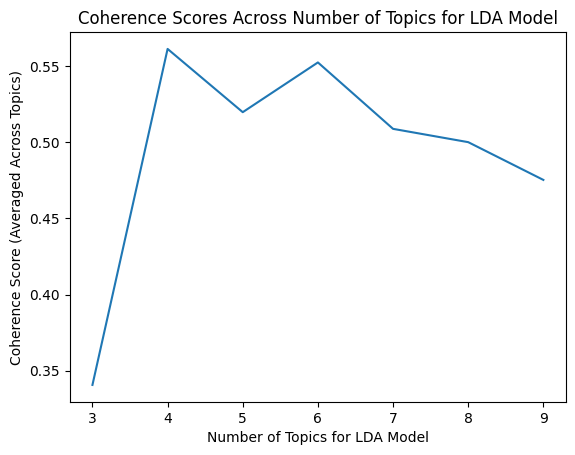

In [ ]:
# Visualization: Plot coherence scores vs. number of topics

plt.plot(num_topics, coherence_scores)
plt.xlabel("Number of Topics for LDA Model")
plt.ylabel("Coherence Score (Averaged Across Topics)")
plt.title("Coherence Scores Across Number of Topics for LDA Model")
plt.show()

In [ ]:
# From the above, we see that 4 is a decent number of topics to use
n = 4
ldag_4 = LdaModel(corpus=lyrics_bow, id2word=D, num_topics=n)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Visualization: Topic modeling using pyLDAvis

vis_data = gensimvis.prepare(ldag_4, lyrics_bow, D)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Given an LDA model trained on 6 topics, let's select the topics with the largest coherence

coherence_model = CoherenceModel(model=ldag_4, texts=corpus, dictionary=D, coherence='c_v')
coherence_per_topic = coherence_model.get_coherence_per_topic()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


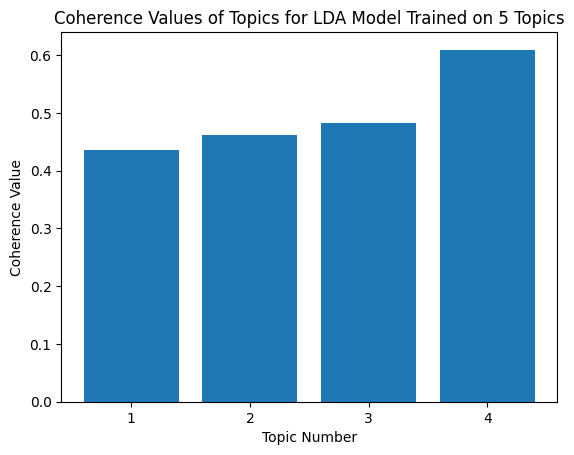

In [ ]:
# Visualization: Display the topics in order of decreasing coherence

# Save in dictionary of topic # and coherence for that topic
topic_coherences = {}
for i in range(n):
    topic_coherences[i+1] = coherence_per_topic[i]

# Plot in descending order of coherences
sorted_dict = sorted(topic_coherences.items(), key=lambda x: x[1], reverse=True)
topics = [i[0] for i in sorted_dict]
coherences = [i[1] for i in sorted_dict]
plt.bar(topics, coherences)
plt.xlabel('Topic Number')
plt.ylabel('Coherence Value')
plt.title('Coherence Values of Topics for LDA Model Trained on 5 Topics')
plt.xticks(topics)
plt.show()

#### Identify Top Tracks Per Topic, and Topic Themes

In [ ]:
def print_top_documents_by_topic(lda_model, bow, topn):
    topic_matrix = [lda_model.get_document_topics(doc, minimum_probability=0) for doc in bow]
    seen_tracks = set()

    # Iterate through topics
    for topic_id in range(lda_model.num_topics):
        print(f"Top tracks for topic {topic_id+1}:")
        topic_contributions = [(i, doc_topics[topic_id][1]) for i, doc_topics in enumerate(topic_matrix)]
        top_doc_indices = sorted(topic_contributions, key=lambda x: -x[1])

        # Print top tracks
        count = 0
        for index, _ in top_doc_indices:
            track_name = final_df.iloc[index]['Track Name']
            artist_name = final_df.iloc[index]['Artist Name']
            unique_identifier = f"{track_name} by {artist_name}"
            if unique_identifier not in seen_tracks:
                print(f" - {track_name} by {artist_name}")
                seen_tracks.add(unique_identifier)
                count += 1
            if count >= topn:
                break
        print("\n")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Display the 4 topics, as well as the top 5 tracks per topic
print_top_documents_by_topic(ldag_4, lyrics_bow, 5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top tracks for topic 1:
 - Fake Love by Drake
 - Every Single Thing by HOMESHAKE
 - Big Green Tractor by Jason Aldean
 - Fallen by Mýa
 - Bed by J. Holiday


Top tracks for topic 2:
 - Just The Two Of Us (feat. Bill Withers) by Grover Washington, Jr.
 - Kush & Corinthians by Kendrick Lamar
 - Eres by Café Tacvba
 - Super Rich Kids by Frank Ocean
 - Make It Wit Chu by Queens of the Stone Age


Top tracks for topic 3:
 - Forrest Gump by Frank Ocean
 - Redefined (feat. Melanie Fontana & Novaspace) [Club Mix] by tyDi
 - Tennis Court by Lorde
 - I'm Still Standing - From "Sing" Original Motion Picture Soundtrack by Taron Egerton
 - Lost by Frank Ocean


Top tracks for topic 4:
 - Nights by Frank Ocean
 - Brokenhearted by Kalin and Myles
 - 7 Years by Lukas Graham
 - Jungle by Drake
 - Not Today by Twenty One Pilots




Based on some analysis of the above output, this is what we propose as semantic interpretations of each of the topics:

* Topic 1: Life + Personal Struggles
* Topic 2: Relationships
* Topic 3: Self-Empowerment
* Topic 4: Nostalgic Reflection on Life



#### Tag Each Document with its Dominant Topic

In [ ]:
# Getting the dominant topic for each document
dominant_topics = []
for doc in lyrics_bow:
    topic_probs = ldag_4.get_document_topics(doc)
    dominant_topic = sorted(topic_probs, key=lambda x: -x[1])[0][0]
    dominant_topics.append(dominant_topic)

# Creating a mapping from numerical topics to custom labels
topic_labels = {
    0: 'Life + Struggles',
    1: 'Relationships',
    2: 'Self-Empowerment + Confident',
    3: 'Nostalgic Reflection on Life'
}

# Topic tagging for
final_df['Dominant Topic'] = [topic_labels[topic] for topic in dominant_topics]
final_df['Dominant Topic Probability'] = [max(ldag_4.get_document_topics(doc), key=lambda x: x[1])[1] for doc in lyrics_bow]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
final_df[['Track Name', 'Artist Name', 'Dominant Topic', 'Dominant Topic Probability']].head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Track Name,Artist Name,Dominant Topic,Dominant Topic Probability
0,Take My Side,Will Butler,Self-Empowerment + Confident,0.921849
1,Everyday it Starts,Parquet Courts,Life + Struggles,0.501700
2,Content Nausea,Parquet Courts,Self-Empowerment + Confident,0.893172
3,Slide Machine,Parquet Courts,Relationships,0.989260
4,Pretty Machines,Parquet Courts,Self-Empowerment + Confident,0.749053


#### Visualize Topics and Tokens

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


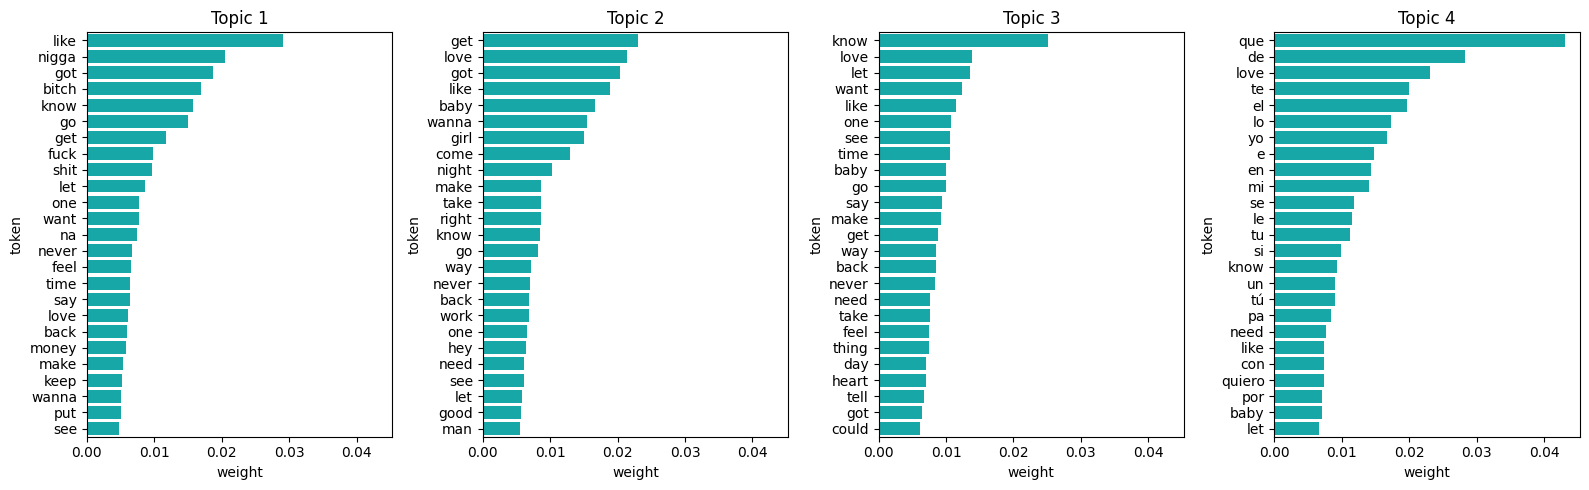

In [ ]:
# There is some profanity amongst the tokens that will be displayed. Sorry!

# Visualization: Display the first 10 topics as a series of bar diagrams with the top 25 tokens of each topic

topn_tokens = 25
# Create 1x5 grid of bar charts
fig, axes = plt.subplots(1, 4, figsize=(16, 5), sharex=True)
for i, ax in enumerate(axes.flatten()):
    if i < 4:
        # Make dataframe with columns 'token' and 'weight' for topic i
        df = pd.DataFrame(ldag_4.show_topic(i, topn=topn_tokens), columns=['token', 'weight'])
        sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=ax)
        ax.set_title('Topic ' + str(i+1))
plt.tight_layout()
plt.show()


### Analyzing GloVe: K-means Clustering

#### Elbow Method + Silhouette Scores to find Optimal k

In [ ]:
# Calculate inertia and silhouette scores for a range of k values

final_df = final_df.dropna(subset=['Lyrics Embedding'])
X = np.array(list(final_df['Lyrics Embedding']))

inertia = []
silhouette_scores = []
K = range(2, 6)  # Choice of K justified by considering the num topics from LDA

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

    # Calculate silhouette score only if more than 1 cluster is present
    if k > 1:
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


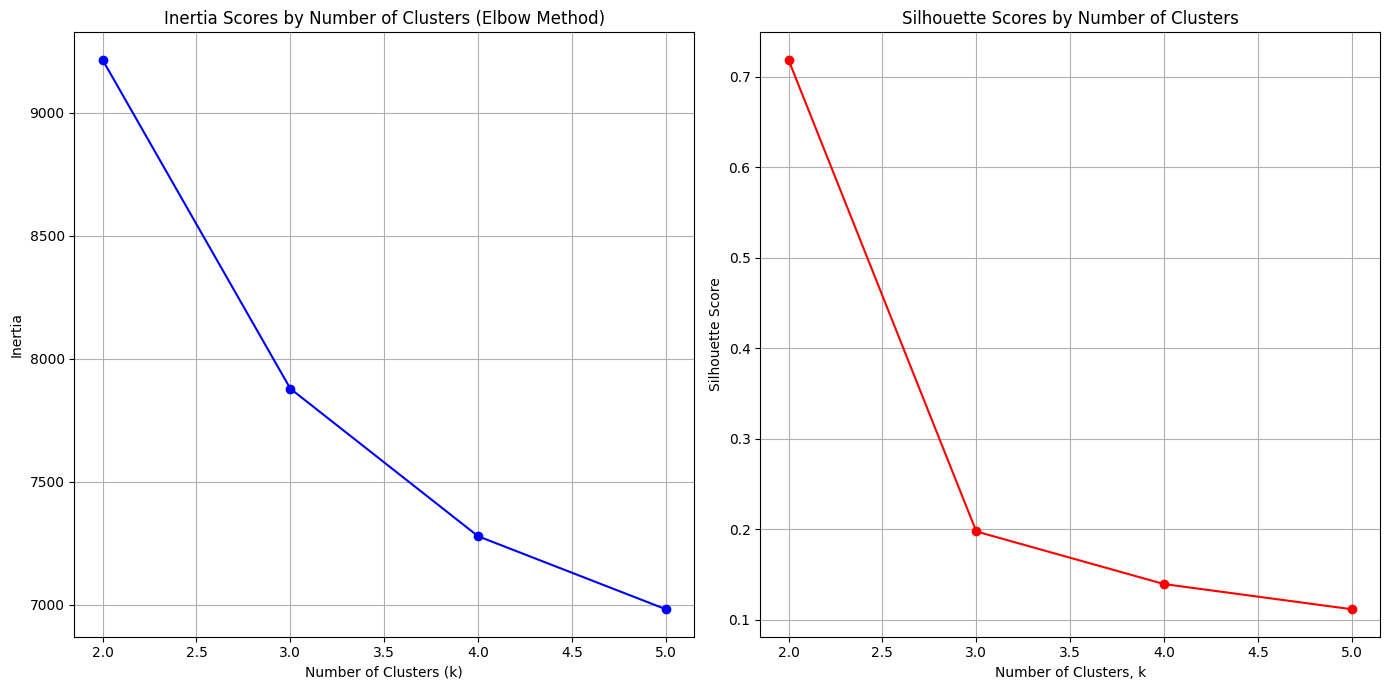

In [ ]:
# Plot Inertia & Silhouette Scores by Number of Clusters

# Plotting the Elbow Graph
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Inertia Scores by Number of Clusters (Elbow Method)')
plt.grid(True)

# Plotting the Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'ro-')  # Skip the first k=1 as silhouette is not defined for k=1
plt.xlabel('Number of Clusters, k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores by Number of Clusters')
plt.grid(True)

plt.tight_layout()
plt.show()

#### PCA Transformation with Optimal K

In [ ]:
# Run PCA transformation on Lyrics Embedding
# Note that we would also do this for Playlist Name Embedding, but there were too many NaN values (likely due to there being small number of tokens)

k=3
keep_cols = ['Track Name', 'Lyrics Embedding']
pca_df = final_df[keep_cols].copy()
pca = PCA(n_components=3)
lyrics_embeddings = np.array(final_df['Lyrics Embedding'].tolist())
lyrics_pca = pca.fit_transform(lyrics_embeddings)

# Add transformed data to dataframe for plotting
for i in range(lyrics_pca.shape[1]):
    pca_df[f'Lyrics PCA {i+1}'] = lyrics_pca[:, i]

# Print the explained variance ratio
print("Explained Variance Ratio of each PC:", pca.explained_variance_ratio_)

Explained Variance Ratio of each PC: [0.5553543  0.06814776 0.06316371]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
pca_df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Track Name,Lyrics Embedding,Lyrics PCA 1,Lyrics PCA 2,Lyrics PCA 3
0,Take My Side,"[0.14704275, 0.18749574, 0.027559102, -0.36198...",-0.489290,0.092027,-0.194419
1,Everyday it Starts,"[0.14214703, 0.13033065, -0.1995055, -0.361942...",-0.536118,-0.073265,-0.183350
2,Content Nausea,"[0.2363391, 0.17119373, 0.03917369, -0.2821858...",-0.497719,0.491201,-0.229695
3,Slide Machine,"[-0.04323885, -0.032407302, 0.3804018, -0.9310...",0.414873,-0.530086,0.481148
4,Pretty Machines,"[0.11442823, 0.0718515, 0.057495397, -0.275225...",-0.409956,0.080249,-0.296959


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


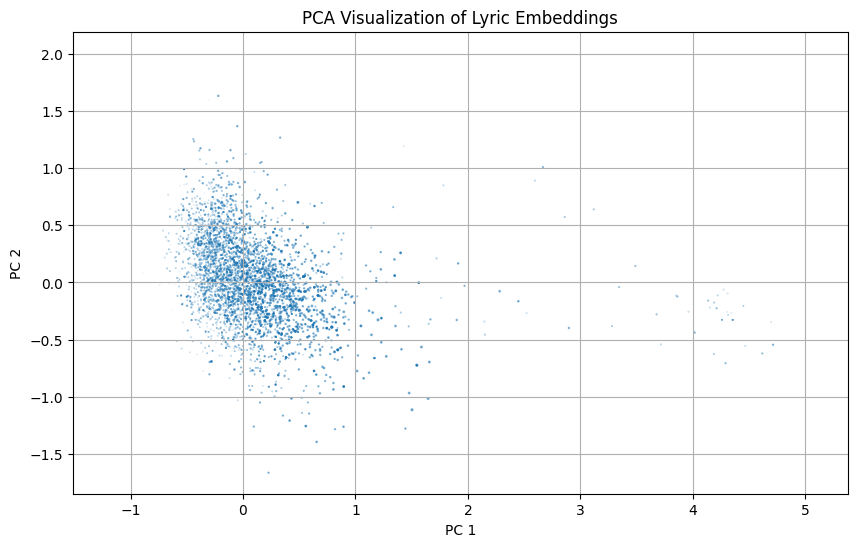

In [ ]:
# Visualization: PCA with k=3

plt.figure(figsize=(10, 6))
plt.scatter(pca_df['Lyrics PCA 1'], pca_df['Lyrics PCA 2'],pca_df['Lyrics PCA 3'],alpha=0.5)
plt.title('PCA Visualization of Lyric Embeddings')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.grid(True)
plt.show()

#### Save dataframe (with lyric embeddings) to csv

In [ ]:
final_df.to_csv('playlist_with_embeddings_dataset.csv', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
